In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from grn_benchmark.src.helper import plot_heatmap, DATASETS
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# make sure each column can use more horizontal space
pd.set_option('display.max_colwidth', None)

In [3]:
# !ls resources/results/op/

In [7]:
ad.read_h5ad('resources/results/op/op.geneformer.geneformer.prediction.h5ad').uns

{'dataset_id': 'op',
 'method_id': 'scprint',
 'prediction':            source   target                 weight cell_type
 21789421   ZNF253     CCL4    0.02587067149579525   B cells
 4531479      KLF2    CCL22    0.02558579482138157   B cells
 9523105      TCF7  ATP5IF1    0.02061706781387329   B cells
 16846828    CEBPB    FKBP5     0.0187208391726017   B cells
 18169526  ZNF585B    AP3S2    0.01858028955757618   B cells
 ...           ...      ...                    ...       ...
 14784521      JUN      RAN  0.0014096290105953813  NK cells
 1766113     RUNX3    MORC3   0.001409625168889761  NK cells
 11477896   ZNF37A     NUS1   0.001409625168889761  NK cells
 1693307      AKNA   BTN3A2  0.0014096165541559458  NK cells
 17052508     LEF1     TGS1  0.0014096042141318321  NK cells
 
 [400000 rows x 4 columns]}

In [ ]:
!ls /vol/projects/jnourisa/datasets/sc/data12_sc.h5ad

 CXCL9_sc.h5ad			       data13_Thai_sc.h5ad
 data12_sc.h5ad			       data1_sc.h5ad
 data13_European_sc.h5ad	       data7_allTPs_jalil_sc.h5ad
 data13_Indian_sc.h5ad		       ibd_atac.h5ad
 data13_Japanese_sc.h5ad	       ibd_rna.h5ad
 data13_Korean_sc.h5ad		       op_sc.h5ad
'data13_Singaporean Chinese_sc.h5ad'   rna_IBD.h5ad
'data13_Singaporean Indian_sc.h5ad'    SLE_Asian_sc.h5ad
'data13_Singaporean Malay_sc.h5ad'     SLE_European_sc.h5ad


In [2]:
adata = ad.read_h5ad('/vol/projects/jnourisa/datasets/sc/data12_sc.h5ad', backed='r')

In [3]:
adata

AnnData object with n_obs × n_vars = 538266 × 20013 backed at '/vol/projects/jnourisa/datasets/sc/data12_sc.h5ad'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'age', 'sex', 'batch_info', 'ct_major_published', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Major_CT', 'Sub_CT', 'dataset', 'cell_type', 'donor_age'

In [19]:
from src.utils.util import fetch_gene_info
df_annot = fetch_gene_info()[['gene_id']]

In [30]:
adata = ad.read_h5ad('resources/grn_benchmark/inference_data/ibd_rna.h5ad')

In [33]:
def add_gene_id(adata):
    from src.utils.util import fetch_gene_info

    # fetch_gene_info should return a DataFrame with index = gene_name or gene_symbol
    df_annot = fetch_gene_info()[['gene_id']]

    # Merge annotations on the variable index (gene names)
    merged = adata.var.merge(df_annot, left_index=True, right_index=True, how='left')
    
    # Keep only genes with known gene_id (to avoid mismatch)
    valid_genes = merged.dropna().index

    # Subset AnnData to match valid genes
    adata = adata[:, valid_genes].copy()

    # Assign the merged annotation back
    adata.var = merged.loc[valid_genes]

    return adata
adata = add_gene_id(adata)

In [35]:
adata.var

,gene_id
LINC01409,ENSG00000237491
LINC01128,ENSG00000228794
LINC00115,ENSG00000225880
FAM41C,ENSG00000230368
SAMD11,ENSG00000187634
...,...
PLAC1,ENSG00000170965
LINC00892,ENSG00000233093
HAUS7,ENSG00000213397
L1CAM,ENSG00000198910


/home/jnourisa/projs/ongoing/grn_benchmark/src/helper.py:253: RuntimeWarning: All-NaN axis encountered
  scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)
/home/jnourisa/projs/ongoing/grn_benchmark/src/helper.py:253: RuntimeWarning: All-NaN axis encountered
  scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)
/home/jnourisa/projs/ongoing/grn_benchmark/src/helper.py:253: RuntimeWarning: All-NaN axis encountered
  scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)
/home/jnourisa/projs/ongoing/grn_benchmark/src/helper.py:253: RuntimeWarning: All-NaN axis encountered
  scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)
/home/jnourisa/projs/ongoing/grn_benchmark/src/helper.py:253: RuntimeWarning: All-NaN axis encountered
  scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) /

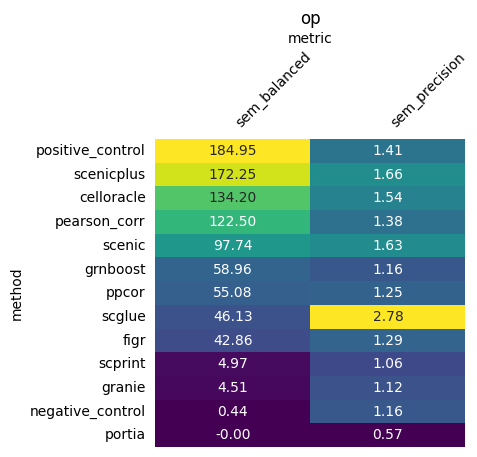

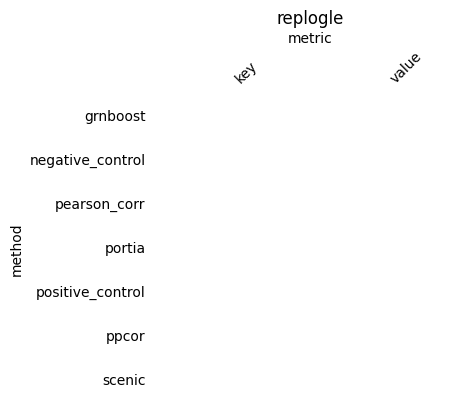

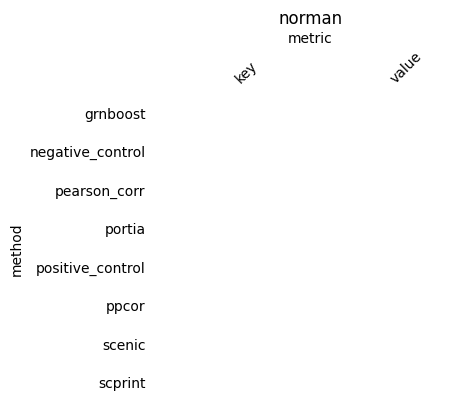

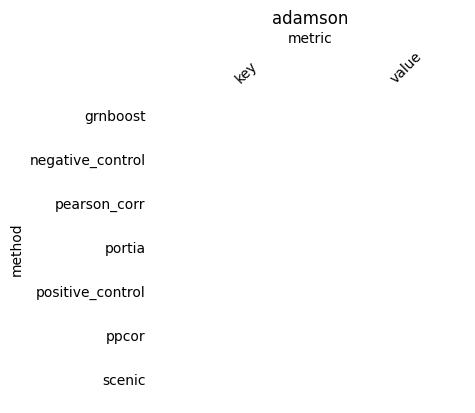

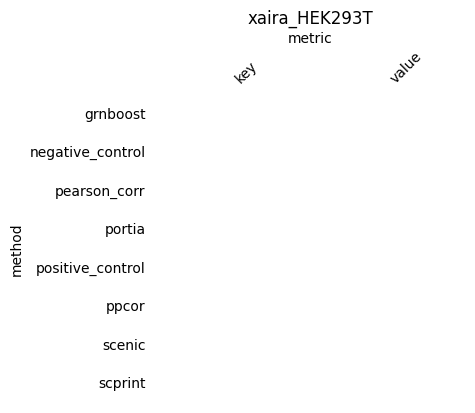

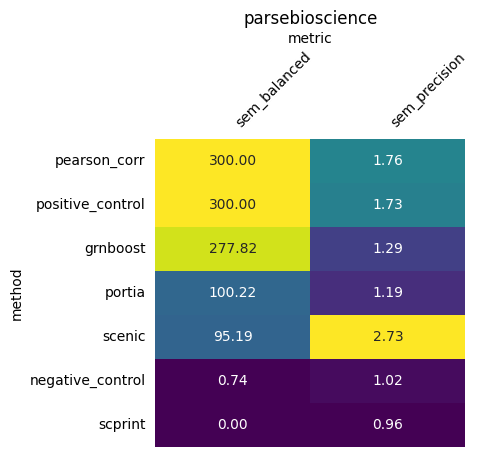

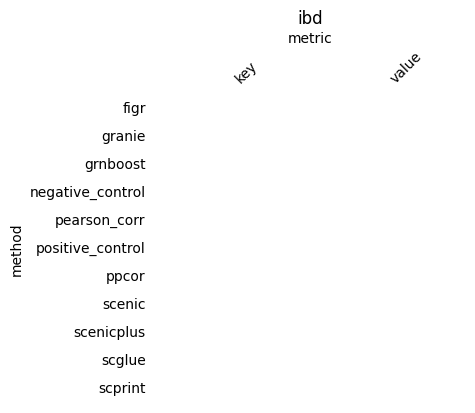

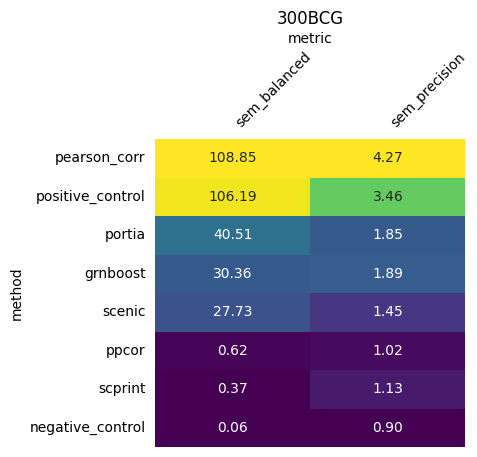

In [10]:
metric = 'sem'
for dataset in DATASETS:
    try:
        df = pd.read_csv(f'output/{metric}/{metric}_scores_{dataset}.csv')
    except:
        continue
    df = df.pivot(index='method', columns='metric', values='value')
    df.sort_values(df.columns[0], ascending=False, inplace=True)
    plot_heatmap(df, name='',  cmap="viridis")
    plt.title(f'{dataset}')
    # print('\n\n', dataset, '\n', df)

# Assemble the results from differnet runs

In [ ]:
!rm -r resources/results/all_main/

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
from collections import OrderedDict

base_dir = 'resources/results/'
save_dir = 'resources/results/all_main/'
runs = ['op', 'nakatake', 'norman', 'replogle', 'adamson']

os.makedirs(save_dir, exist_ok=True)

# 1. Copy one version of the identical files
identical_files = ['method_configs.yaml', 'metric_configs.yaml']
for fname in identical_files:
    src = os.path.join(base_dir, f'{runs[0]}_run', fname)
    dst = os.path.join(save_dir, fname)
    shutil.copyfile(src, dst)
    print(f"Copied identical file: {fname}")

# 2. Merge dataset_uns.yaml by appending all contents
merged_uns = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'dataset_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        merged_uns.extend(data)
        
with open(os.path.join(save_dir, 'dataset_uns.yaml'), 'w') as f:
    yaml.dump(merged_uns, f)
print("Merged: dataset_uns.yaml")

# 3. Merge score_uns.yaml similarly
merged_scores = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'score_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        # - remove those with missing (because of the metric)
        data = [d for d in data if d is not None and 'missing' not in str(d)]
        
        # print(str(data[0]))
        # aa
        # missing
        if data:
            if isinstance(data, dict):
                merged_scores.append(data)
            elif isinstance(data, list):
                merged_scores.extend(data)
            else:
                print(f"Unexpected format in {path}: {type(data)}")

with open(os.path.join(save_dir, 'score_uns.yaml'), 'w') as f:
    yaml.dump(merged_scores, f)
print("Merged: score_uns.yaml")

# 4. Merge trace.txt with deduplication
seen_lines = OrderedDict()
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'trace.txt')
    
    with open(path, 'r') as f:
        for line in f:
            seen_lines[line] = None

with open(os.path.join(save_dir, 'trace.txt'), 'w') as f:
    for line in seen_lines.keys():
        f.write(line)
df = pd.read_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
df = df.drop_duplicates(subset=['name'])
df.to_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
print("Merged: trace.txt (duplicates removed)")

# 5. Copy other unknown files/directories
all_known = set(identical_files + ['dataset_uns.yaml', 'score_uns.yaml', 'trace.txt'])

for run in runs:
    run_dir = Path(base_dir) / f'{run}_run'
    for file_path in run_dir.iterdir():
        if file_path.name in all_known:
            continue

        dest_path = Path(save_dir) / file_path.name

        if dest_path.exists():
            dest_path = Path(save_dir) / f"{file_path.stem}_{run}{file_path.suffix}"

        if file_path.is_file():
            shutil.copyfile(file_path, dest_path)
            print(f"Copied unique file: {file_path.name} → {dest_path.name}")
        elif file_path.is_dir():
            shutil.copytree(file_path, dest_path)
            print(f"Copied unique directory: {file_path.name} → {dest_path.name}")

Copied identical file: method_configs.yaml
Copied identical file: metric_configs.yaml
Merged: dataset_uns.yaml
Merged: score_uns.yaml
Merged: trace.txt (duplicates removed)
Copied unique file: state.yaml → state.yaml
Copied unique file: op_.celloracle.celloracle.prediction.h5ad → op_.celloracle.celloracle.prediction.h5ad
Copied unique file: scplus_mdata.h5mu.2DAaAA8E → scplus_mdata.h5mu.2DAaAA8E
Copied unique file: op_.negative_control.negative_control.prediction.h5ad → op_.negative_control.negative_control.prediction.h5ad
Copied unique file: op_.scenicplus.scenicplus.prediction.h5ad → op_.scenicplus.scenicplus.prediction.h5ad
Copied unique file: op_.portia.portia.prediction.h5ad → op_.portia.portia.prediction.h5ad
Copied unique file: op_.granie.granie.prediction.h5ad → op_.granie.granie.prediction.h5ad
Copied unique file: op_.scprint.scprint.prediction.h5ad → op_.scprint.scprint.prediction.h5ad
Copied unique file: op_.pearson_corr.pearson_corr.prediction.h5ad → op_.pearson_corr.pearso